In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np
from plot.losses import get_least_cum_losses, get_averaged_cum_losses
from plot.format import set_size

In [3]:
width = 345
tex_fonts = {
    # Use LaTeX to write all text
    #"text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 8.5,
    "ytick.labelsize": 8.5
}

plt.rcParams.update(tex_fonts)

In [4]:
paper_figures_dir = "../figures/"
algo_labels = {
    'center-based-exp3': 'center-based Exp3',
    'center-based-tsallis': 'CFTRL',
    'distributed-exp3': 'Exp3-COOP',
    'distributed-hybrid': 'DFTRL'
}
linestyles= {
    'center-based-tsallis': '-',
    'center-based-exp3': ':',
    'distributed-exp3': '-.',
    'distributed-hybrid': '--'
}
markers = {
    'center-based-tsallis': '^',
    'center-based-exp3': 'o',
    'distributed-exp3': '<',
    'distributed-hybrid': '>'
}

## Figure 1
### Regret

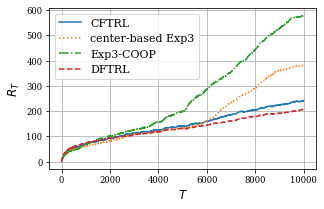

In [25]:
path_to_dir = "../experiments/coin_flip_regular_graph/"
seed_algo_list = list(range(10))
network_list = ['center-based', 'distributed']
algo_list = ['tsallis', 'exp3', 'hybrid']

hyper_parameters = {
    'network': None,
    'algo': None,
    'rounds': 10000,
    'n_actions': 40,
    'seed_adversary': 1,
    'delay': 1,
    'n_agents': 3,
    'degree': 2,
    'seed_nx': 0,
    'seed_algo': None,
    'learning_rate': 0.1
}

least_cum_loss = get_least_cum_losses(hyper_parameters)

all_averaged_cum_regrets = {}
ci_averaged_cum_regrets = {}
for network in network_list:
    for algo in algo_list:
        key = network+'-'+algo
        if not (key == 'center-based-hybrid' or key == 'distributed-tsallis'):
            all_averaged_cum_regrets[key] = []
            hyper_parameters['network'] = network
            hyper_parameters['algo'] = algo
            # axis-0: seed, axis-1: time step
            for seed in seed_algo_list:
                hyper_parameters['seed_algo'] = seed
                all_averaged_cum_regrets[key].append(
                    (get_averaged_cum_losses(hyper_parameters, path_to_dir) - least_cum_loss).tolist()
                )
            ci_averaged_cum_regrets[key] = {
                '5pct': np.percentile(all_averaged_cum_regrets[key], q=5, axis=0),
                'mean': np.average(all_averaged_cum_regrets[key], axis=0),
                '95pct': np.percentile(all_averaged_cum_regrets[key], q=95, axis=0),
            }

fig, ax0 = plt.subplots(1, 1, figsize=set_size(width))
for network_agents, ci in ci_averaged_cum_regrets.items():
    ax0.plot(
        list(range(hyper_parameters['rounds'])),
        ci['mean'],
        linestyle=linestyles[network_agents],
        label=algo_labels[network_agents]
    )
    # ax0.fill_between(
    #     list(range(hyper_parameters['rounds'])),
    #     ci['5pct'],
    #     ci['95pct'],
    #     alpha=0.2
    # )

ax0.set_ylabel(r"$R_T$")
ax0.set_xlabel(r"$T$")
ax0.legend(loc="upper left")
plt.grid()
plt.show()
fig.savefig(paper_figures_dir+"regret.pdf", format='pdf', bbox_inches='tight')

### Actions

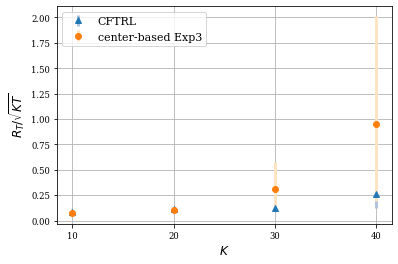

In [26]:
ci_averaged_cum_regrets = {
    'center-based-tsallis': {
        '5pct': np.array([24.49473792, 49.23335374, 63.2479954 , 78.11844996]),
        'mean': np.array([ 26.89555663,  51.23217386,  69.27550082, 167.28165476]),
        '95pct': np.array([ 29.83197245,  53.01308931,  79.27935911, 287.23936579])
    },
    'center-based-exp3': {
        '5pct': np.array([ 20.57587024,  38.6570358 ,  75.93231726, 124.02444103]),
        'mean': np.array([ 24.44924678,  45.07131708, 169.66446431, 600.17528461]),
        '95pct': np.array([  27.17457656,   52.85960779,  318.25767056, 1271.99388722])
    }
}

n_actions_list = list(range(10, 50, 10))

normalizer = [(K*hyper_parameters['rounds'])**.5 for K in n_actions_list]

errbar_colors = {
    'center-based-tsallis': ['C0', 'lightsteelblue'],
    'center-based-exp3': ['C1', 'bisque']
}

fig, ax1 = plt.subplots(1, 1)
for network_agents, ci in ci_averaged_cum_regrets.items():
    ax1.errorbar(
        n_actions_list,
        ci['mean'] / normalizer,
        yerr=[
            (ci['mean'] - ci['5pct'])/normalizer,
            (ci['95pct'] - ci['mean'])/normalizer
        ],
        label=algo_labels[network_agents],
        color=errbar_colors[network_agents][0],
        ecolor=errbar_colors[network_agents][1],
        fmt=markers[network_agents], elinewidth=3, capsize=0
    )

ax1.set_ylabel(r"$R_T/\sqrt{KT}$")
ax1.set_xlabel(r"$K$")
ax1.legend(loc="upper left")
ax1.set_xticks(n_actions_list)
plt.grid()
plt.show()
fig.savefig(paper_figures_dir+"n_actions.pdf", format='pdf', bbox_inches='tight')

## Figure 2
### Degree

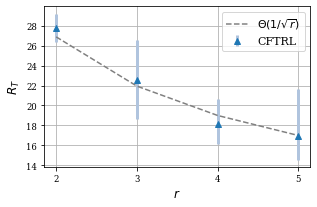

In [27]:
ci_averaged_cum_regrets = {
    'center-based-tsallis': {
        '5pct': np.array([26.37015428, 18.63628396, 16.19019338, 14.58829116]),
        'mean': np.array([27.71262888, 22.58307615, 18.18402126, 16.98922847]),
        '95pct': np.array([29.19121962, 26.58581586, 20.65908112, 21.6667973 ])
    }
    # 'distributed-hybrid': {
    #     '5pct': np.array([34.34579505, 30.73770046, 22.52284971, 17.74499825]),
    #     'mean': np.array([40.07776303, 36.61493927, 25.21853789, 18.68519834]),
    #     '95pct': np.array([45.48882972, 42.15010806, 28.72346299, 20.01821454])
    # }
}

degree_list = list(range(2,6))
errbar_colors = {
    'center-based-tsallis': ['C0', 'lightsteelblue']
    # 'distributed-hybrid': ['C1', 'bisque']
}

fig, ax4 = plt.subplots(1, 1, figsize=set_size(width))
for network_agents, ci in ci_averaged_cum_regrets.items():
    ax4.errorbar(
        degree_list,
        ci['mean'],
        yerr=[
            ci['mean'] - ci['5pct'],
            ci['95pct'] - ci['mean']
        ],
        label=algo_labels[network_agents],
        color=errbar_colors[network_agents][0],
        ecolor=errbar_colors[network_agents][1],
        fmt=markers[network_agents], elinewidth=3, capsize=0
    )

ax4.plot(degree_list, [38/delta**.5 for delta in degree_list], '--', color='grey', label='$\Theta(1/\sqrt{r})$')

ax4.set_ylabel(r"$R_T$")
ax4.set_xlabel(r"$r$")
ax4.legend(loc="upper right")
ax4.set_xticks(degree_list)
plt.grid()
plt.show()
fig.savefig(paper_figures_dir+"degree.pdf", format='pdf', bbox_inches='tight')

### Delays

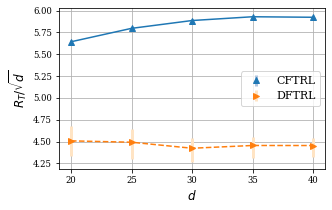

In [9]:
ci_averaged_cum_regrets = {
    'center-based-tsallis': {
        '5pct': np.array([25.15090774, 28.91269875, 32.18900792, 35.02923438, 37.44297781]),
        'mean': np.array([25.23905242, 28.98796168, 32.24607469, 35.08611984, 37.47029373]),
        '95pct': np.array([25.35112869, 29.08809225, 32.33936188, 35.15650404, 37.50217858])
    },
    'distributed-hybrid': {
        '5pct': np.array([19.37993706, 21.51188687, 23.39085799, 25.51864315, 27.36980579]),
        'mean': np.array([20.15735887, 22.45859857, 24.2241305 , 26.35252183, 28.16816849]),
        '95pct': np.array([20.93917618, 23.21334734, 24.88154647, 26.90624495, 28.70209104])
    }
}

delay_list = list(range(20, 45, 5))
normalizer = [de**.5 for de in delay_list]
fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
errbar_colors = {
    'center-based-tsallis': ['C0', 'lightsteelblue'],
    'distributed-hybrid': ['C1', 'bisque']
}

for network_agents, ci in ci_averaged_cum_regrets.items():
    ax1.errorbar(
        delay_list,
        ci['mean']/normalizer ,
        yerr=[
            (ci['mean'] - ci['5pct'])/normalizer,
            (ci['95pct'] - ci['mean'])/normalizer
        ],
        label=algo_labels[network_agents],
        color=errbar_colors[network_agents][0],
        ecolor=errbar_colors[network_agents][1],
        fmt=markers[network_agents], elinewidth=3, capsize=0
    )

    ax1.plot(
        delay_list,
        ci['mean']/normalizer,
        linestyle=linestyles[network_agents]
    )

ax1.set_ylabel(r"$R_T/\sqrt{d}$")
ax1.set_xlabel(r"$d$")
ax1.legend(loc="center right")
ax1.set_xticks(delay_list)
plt.grid()
plt.show()
fig.savefig(paper_figures_dir+"delay.pdf", format='pdf', bbox_inches='tight')

### Erdos-Renyi graph

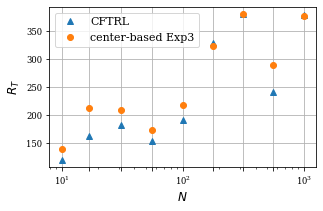

In [30]:
all_averaged_cum_regrets = {
    'center-based-tsallis': [
        119.97446631053137,
        163.4208988151317,
        182.12890653513557,
        154.90907191850064,
        192.20218780393537,
        329.58281698119873,
        380.4019870730631,
        242.32048784997068,
        379.8276792829796
    ],
    'center-based-exp3': [
        139.7073463770852,
        213.58735074051174,
        208.60853951118816,
        173.9890959972701,
        218.5981111503312,
        324.35246256558304,
        380.3206698292546,
        290.0258623535946,
        377.6430353433467
    ]
}
n_agents_list = [int(10**expo) for expo in np.linspace(1, 3, 9)]
errbar_colors = {
    'center-based-tsallis': ['C0', 'lightsteelblue'],
    'center-based-exp3': ['C1', 'bisque']
}

fig, ax5 = plt.subplots(1,1, figsize=set_size(width))
for network_agents, vals in all_averaged_cum_regrets.items():
    regrets = all_averaged_cum_regrets[network_agents]
    ax5.errorbar(
        n_agents_list,
        regrets,
        label=algo_labels[network_agents],
        color=errbar_colors[network_agents][0],
        ecolor=errbar_colors[network_agents][1],
        fmt=markers[network_agents], elinewidth=3, capsize=0
    )
ax5.set_xscale('log')
ax5.set_ylabel(r"$R_T$")
ax5.set_xlabel(r"$N$")
ax5.legend(loc="upper left")
ax5.set_xticks(n_agents_list)
plt.grid()
plt.show()
fig.savefig(paper_figures_dir+"erdos_renyi.pdf", format='pdf', bbox_inches='tight')